# **06 Data Cleaning and Feature Engineering**

## Objectives

* clean data and engineer features for modelling
- ETL: Impute/handle missing values
- ETL: Treat outliers
- ETL: Encode categoricals
- ETL: Scale/normalise features
- ETL: Engineer domain features
- ETL: Save cleaned dataset

## Inputs

* Merged housing data sources data file: ppd_with_geography_and_imd_epc.csv

## Outputs

* housing.csv

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# - ETL: Impute/handle missing values

Load libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.pipeline import Pipeline

In [8]:
# load the data
df = pd.read_csv('../data/clean/ppd_with_geography_and_imd_epc.csv')
df.head()

,transaction,price,transfer_date,postcode,property_type,new_build,tenure,PAON,SAON,Street,...,msoa11nm,ladnm,IMD_Decile,IMD_Rank,addr_key,exact_key_no_saon,current_energy_rating,total_floor_area,matched_key,match_score
0,{3DCCB7C9-D239-5B9D-E063-4704A8C0331E},340000,2003-11-28 00:00,DE73 7JQ,S,N,F,COBWEB BARN,NaN,INGLEBY LANE,...,South Derbyshire 006,South Derbyshire,7.0,20607.0,cobweb barn ingleby lane de73 7jq,cobweb barn ingleby lane de73 7jq,NaN,NaN,NaN,NaN
1,{3DCCB7C9-D364-5B9D-E063-4704A8C0331E},450000,2006-03-17 00:00,DE7 6GU,D,N,F,3,NaN,BEECH LANE,...,Erewash 005,Erewash,10.0,29988.0,3 beech lane de7 6gu,3 beech lane de7 6gu,D,57.0,NaN,NaN
2,{3DCCB7CA-8C58-5B9D-E063-4704A8C0331E},350000,2001-07-19 00:00,CV4 7PA,D,N,F,1,NaN,THE LAURELS,...,Coventry 042,Coventry,9.0,29510.0,1 the laurels cv4 7pa,1 the laurels cv4 7pa,C,354.0,3 the laurels fairlands park cv4 7pa,95.0
3,{3DCCB7CA-1DAB-5B9D-E063-4704A8C0331E},295000,2021-05-21 00:00,LE14 3QL,D,N,F,4,NaN,HOUGHTON CLOSE,...,Melton 003,Melton,6.0,16968.0,4 houghton close le14 3ql,4 houghton close le14 3ql,C,130.0,4 houghton close asfordby hill le14 3ql,100.0
4,{3DCCB7CA-1EF1-5B9D-E063-4704A8C0331E},600000,2021-12-20 00:00,DE73 8LF,D,Y,F,10,NaN,PRIORY CLOSE,...,North West Leicestershire 001,North West Leicestershire,7.0,19826.0,10 priory close de73 8lf,10 priory close de73 8lf,C,193.0,10 priory close breedon on the hill de73 8lf,100.0


---

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7619 entries, 0 to 7618
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transaction            7619 non-null   object 
 1   price                  7619 non-null   int64  
 2   transfer_date          7619 non-null   object 
 3   postcode               7619 non-null   object 
 4   property_type          7619 non-null   object 
 5   new_build              7619 non-null   object 
 6   tenure                 7619 non-null   object 
 7   PAON                   7619 non-null   object 
 8   SAON                   437 non-null    object 
 9   Street                 7581 non-null   object 
 10  Locality               3199 non-null   object 
 11  town_city              7619 non-null   object 
 12  district               7619 non-null   object 
 13  county                 7619 non-null   object 
 14  PPD_category           7619 non-null   object 
 15  Stat

# Section 2

Section 2 content

In [13]:
# check for missing floor area values
df['total_floor_area'].isnull().sum()
# delete rows for missing floor area values
df = df[df['total_floor_area'].notnull()]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7569 entries, 1 to 7618
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transaction            7569 non-null   object 
 1   price                  7569 non-null   int64  
 2   transfer_date          7569 non-null   object 
 3   postcode               7569 non-null   object 
 4   property_type          7569 non-null   object 
 5   new_build              7569 non-null   object 
 6   tenure                 7569 non-null   object 
 7   PAON                   7569 non-null   object 
 8   SAON                   428 non-null    object 
 9   Street                 7531 non-null   object 
 10  Locality               3163 non-null   object 
 11  town_city              7569 non-null   object 
 12  district               7569 non-null   object 
 13  county                 7569 non-null   object 
 14  PPD_category           7569 non-null   object 
 15  Status   

---

 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transaction            7569 non-null   object 
 1   price                  7569 non-null   int64  
 2   transfer_date          7569 non-null   object 
 3   postcode               7569 non-null   object 
 4   property_type          7569 non-null   object 
 5   new_build              7569 non-null   object 
 6   tenure                 7569 non-null   object 
 7   PAON                   7569 non-null   object 
 8   SAON                   428 non-null    object 
 9   Street                 7531 non-null   object 
 10  Locality               3163 non-null   object 
 11  town_city              7569 non-null   object 
 12  district               7569 non-null   object 
 13  county                 7569 non-null   object 
 14  PPD_category           7569 non-null   object 
 15  Status                 7569 non-null   object 
 16  lsoa11cd               7569 non-null   object 
 17  msoa11nm               7569 non-null   object 
 18  ladnm                  7569 non-null   object 
 19  IMD_Decile             7569 non-null   float64
 20  IMD_Rank               7569 non-null   float64
 21  addr_key               7569 non-null   object 
 22  exact_key_no_saon      7569 non-null   object 
 23  current_energy_rating  7569 non-null   object 
 24  total_floor_area       7569 non-null   float64
 25  matched_key            3249 non-null   object 
 26  match_score            3249 non-null   float64

In [14]:
# check data types
df.dtypes
# summary statistics
df.describe()
# check for duplicates
df.duplicated().sum()


0

In [ ]:
"""
drop the columns that are not needed for analysis
Columns marked with * are dropped
0 transaction 7569 non-null object
1 price 7569 non-null int64  
2 transfer_date 7569 non-null object  
3 postcode 7569 non-null object  
4 property_type 7569 non-null object  
5 new_build 7569 non-null object  
6 tenure 7569 non-null object  
7 PAON 7569 non-null object  
8 SAON 428 non-null object  
9 Street 7531 non-null object  
10 Locality 3163 non-null object  
11 town_city 7569 non-null object  
12 district 7569 non-null object  
13 county 7569 non-null object  
*14 PPD_category 7569 non-null object  
*15 Status 7569 non-null object  
16 lsoa11cd 7569 non-null object  
17 msoa11nm 7569 non-null object  
18 ladnm 7569 non-null object  
19 IMD_Decile 7569 non-null float64  
20 IMD_Rank 7569 non-null float64  
*21 addr_key 7569 non-null object  
*22 exact_key_no_saon 7569 non-null object  
23 current_energy_rating 7569 non-null object  
24 total_floor_area 7569 non-null float64  
*25 matched_key 3249 non-null object  
*26 match_score 3249 non-null float64
"""
# drop the columns that are not needed for analysis 
df = df.drop(columns=['PPD_category', 'Status', 'exact_key_no_saon', 'matched_key', 'match_score'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7569 entries, 1 to 7618
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   transaction            7569 non-null   object 
 1   price                  7569 non-null   int64  
 2   transfer_date          7569 non-null   object 
 3   postcode               7569 non-null   object 
 4   property_type          7569 non-null   object 
 5   new_build              7569 non-null   object 
 6   tenure                 7569 non-null   object 
 7   PAON                   7569 non-null   object 
 8   SAON                   428 non-null    object 
 9   Street                 7531 non-null   object 
 10  Locality               3163 non-null   object 
 11  town_city              7569 non-null   object 
 12  district               7569 non-null   object 
 13  county                 7569 non-null   object 
 14  lsoa11cd               7569 non-null   object 
 15  msoa11nm 

In [22]:
# is addr_key unique?
df['addr_key'].is_unique
# are there duplicate addr_key values?
df['addr_key'].duplicated().sum()
# what are the duplicate addr_key values?
df[df['addr_key'].duplicated(keep=False)].sort_values('addr_key')
# keep only the last date for each addr_key
df = df.sort_values('transfer_date').drop_duplicates('addr_key', keep='last')

In [17]:
# date conversion
df['transfer_date'] = pd.to_datetime(df['transfer_date'], errors='coerce')
df['year'] = df['transfer_date'].dt.year

In [26]:
# Use data profiling using ydata_profiling to generate a report to identify any other data quality issues
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_file("../reports/data_profiling_report.html")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 33.46it/s]


**Considerations from the profile report**
alerts in the profile report:

IMD_Decile and IMD_Rank: High correlation
Action: keep only IMD_Decile as a feature

current_energy_rating and new_build: High correlation
New builds usually have a higher EPC.
Action: create an interaction (is_new_build × energy_band_num) 

price and total_floor_area: High correlation
As expected, no action

property_type and tenure: High correlation
Flats are often leasehold
Action: create an interaction flag: is_flat & is_leasehold 

price is highly skewed 
Action: Model log1p(price) as the target (and inverse-transform for reporting).
Action: remove outliers, clipping by property_type


In [ ]:
# create an outcode feature from the postcode column, this may be a useful geographic feature
df['outcode'] = df['postcode'].str.extract(r'^([A-Z]{1,2}\d{1,2}[A-Z]?)')
df['outcode'] = df['outcode'].str.strip()

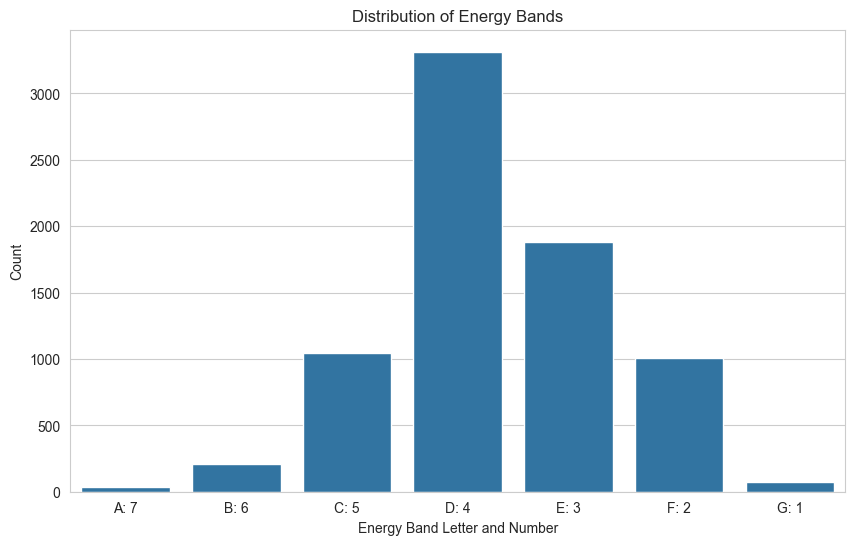

In [35]:
# Energy band A is best, G is worst
# create a new numeric feature energy_band_num where A=7, B=6, C=5, D=4, E=3, F=2, G=1
df['energy_band_num'] = df['current_energy_rating'].map({
    'A': 7,
    'B': 6,
    'C': 5,
    'D': 4,
    'E': 3,
    'F': 2,
    'G': 1
 })

# plot the distribution of energy_band_num
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='energy_band_num')
plt.title('Distribution of Energy Bands')
plt.xlabel('Energy Band Letter and Number')
plt.ylabel('Count')
plt.xticks(ticks=range(7), labels=['A: 7', 'B: 6', 'C: 5', 'D: 4', 'E: 3', 'F: 2', 'G: 1'])
plt.show()


NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---